# Notebook 4: Hierarchical Models

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [139]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [140]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [141]:
import seaborn as sns

def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5, **options)

In [142]:
def plot_kde(sample, **options):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **options)

In [143]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [144]:
def decorate_heads(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of heads (k)')
    plt.ylabel(ylabel)
    plt.title('Distribution of heads')
    legend()

In [145]:
def decorate_proportion(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel(ylabel)
    plt.title('Distribution of proportion')
    legend()

## Two coins

In the previous notebook, we solved a version of the Euro problem, where we estimated the probability that a coin would come up heads.

Now suppose instead of one coin, we have data from two coins.
We spin each coin 250 times.
The first one comes up heads 140 times, as in the previous example.
The second one comes up heads 120 times.

As we did in the hockey example, we can extend the model to estimate the proportion of heads for each coin separately.
Here's a PyMC model that does that.

In [ ]:
n = 250

with pm.Model() as model:
    x1 = pm.Beta('x1', alpha=2, beta=2)
    x2 = pm.Beta('x2', alpha=2, beta=2)
    k1 = pm.Binomial('k1', n=n, p=x1, observed=140)
    k2 = pm.Binomial('k2', n=n, p=x2, observed=110)    

Here's the graphical representation of the model.

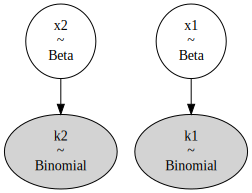

In [147]:
pm.model_to_graphviz(model)

Now let's run the sampler.

In [148]:
with model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2, x1]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Here are the posterior distributions for the two coins.

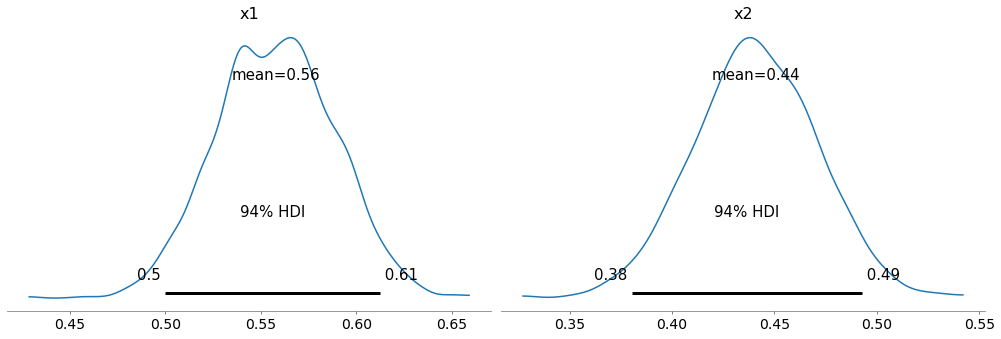

In [149]:
with model:
    az.plot_posterior(trace)

The results for the first coin are about the same as what we saw in the previous notebook. The results for the second coin are similar, but the center of the distribution is lower, because the observed value of `k` is smaller.

This model is not exactly wrong, but it is not as right as it could be, because we are leaving some information on the table.

That's because the data we have about each coin actually provides two kinds of information: it tells us about each coin individually, and it also tells us about coins in general.

By estimating `x1` and `x2` separately, we are using the first kind of information, but not the second.

An alternative is to use a **hierarchical model**.

## Going hierarchical

In the previous model, the prior distribution is a beta distribution with values of `alpha` and `beta` that I chose with the intention of representing the information we have about coins and their probability of coming up heads.
But my choice of these parameters was almost arbitrary.

Instead of choosing these parameters ourselves, an alternative is to add them to the model and use the data to estimate them.

Here's a version of the previous model where `alpha` and `beta` are values drawn from a gamma distribution.

In [151]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
    x1 = pm.Beta('x1', alpha, beta)
    x2 = pm.Beta('x2', alpha, beta)
    k1 = pm.Binomial('k1', n=n, p=x1, observed=140)
    k2 = pm.Binomial('k2', n=n, p=x2, observed=110)

Here's the graph for this model.

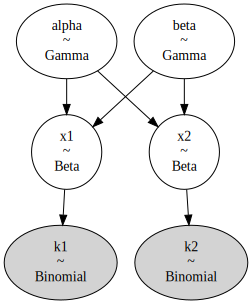

In [152]:
pm.model_to_graphviz(model)

This model is hierarchical because the variables can be arranged in layers.

At the top level, `alpha` and `beta` are **hyperparameters** drawn from a two gamma distributions, which are called **hyperprior distributions**.

At the next level, these hyperparameters are used to define the prior distributions of `x1` and `x2`.

At the bottom level, these parameters are used to define the distributions of `k1` and `k2`, which are the observed values.

Before we sample from the posterior distributions, let's look at the prior and prior predictive distributions.

In [154]:
with model:
    trace = pm.sample_prior_predictive(500)

Here are the distributions of the hyperparameters, `alpha` and `beta`.

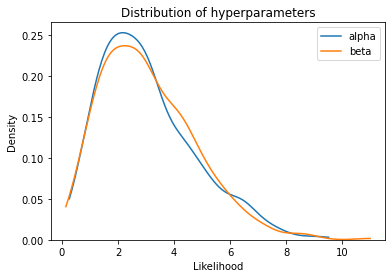

In [156]:
plot_kde(trace['alpha'], label='alpha')
plot_kde(trace['beta'], label='beta')
plt.xlabel('Hyperparameter')
plt.xlabel('Likelihood')
plt.title('Distribution of hyperparameters')
plt.legend();

And here's the prior distributions for `x1` and `x2`.

In [158]:
sample_prior_x1 = trace['x1']
sample_prior_x2 = trace['x2']
sample_prior_x1.mean(), sample_prior_x2.mean()

(0.5076400943871874, 0.4954808501555767)

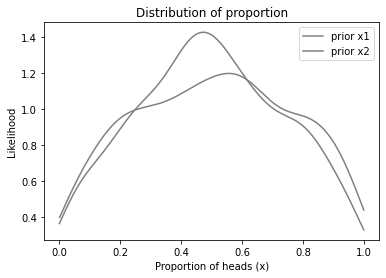

In [162]:
plot_kde(sample_prior_x1, color='gray', label='prior x1')
plot_kde(sample_prior_x2, color='gray', label='prior x2')
decorate_proportion()

The priors for `x1` and `x2` are actually the same, but based on random samples, they look a little different.

Now we're ready to sample from the posteriors.

## Posterior distributions

In [164]:
with model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2, x1, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


And here are the results.

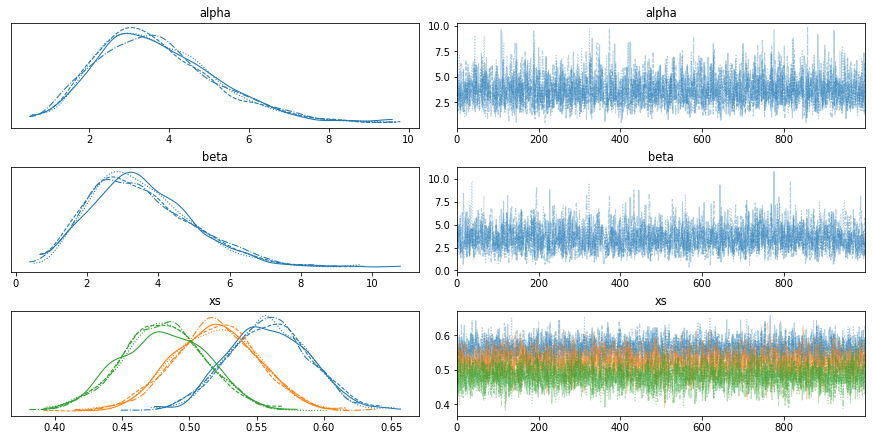

In [95]:
with model:
    az.plot_trace(trace)

Here are the posterior distributions for `x1` and `x2`.

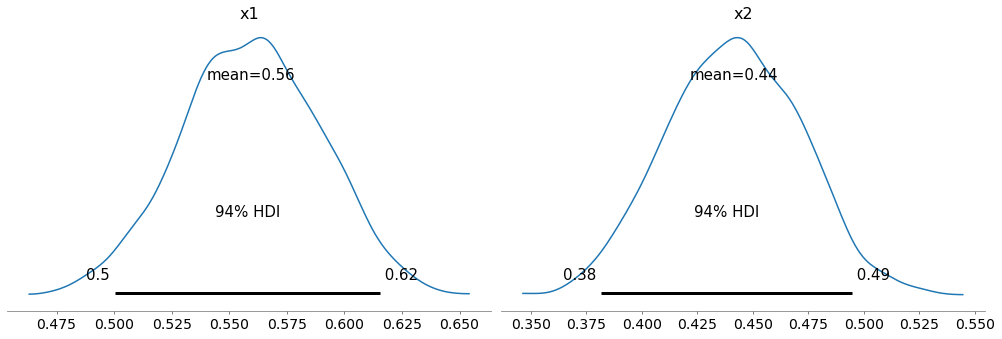

In [166]:
with model:
    az.plot_posterior(trace, var_names=['x1', 'x2'])

In this example, they are not very different from what we got by estimating `x1` and `x2` separately.
If we had less data, the hierarchical model would make more difference.

But even if the distributions of the parameters are the same, the hierarchical model is different because the we have posterior distributions for the hyperparameters, `alpha` and `beta`.

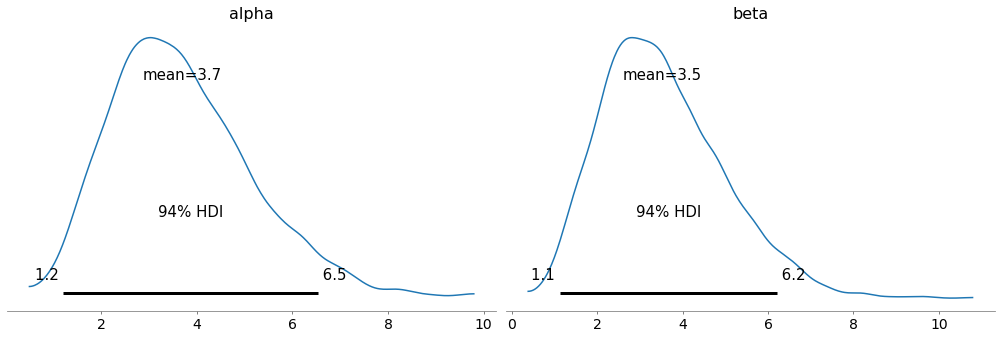

In [96]:
with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta'])

By themselves, they don't mean very much, but we can use them to generate a sample from a beta distribution.

In [167]:
alphas = trace['alpha']
betas = trace['beta']

sample_posterior_x = pm.Beta.dist(alphas, betas).random()
sample_posterior_x.mean()

0.5040832185334927

The result is a distribution that represents what we believe about coins in general, based on the data from both coins.
Here's what it looks like, compared to the prior.

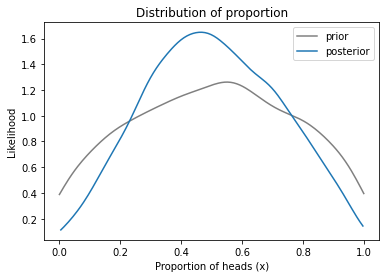

In [168]:
plot_kde(sample_prior_x, color='gray', label='prior')
plot_kde(sample_posterior_x, label='posterior')
decorate_proportion()

The posterior distribution is narrower than the posterior, which means we have more certainty about plausible values of `x`.
Specifically, after seeing this data, we think values of `x` near 0.5 are more likely, and values at the extremes are less likely.

In this example, we don't learn a lot about coins because we don't have a lot of data.
So let's look at an example with more data, where we can see the utility of the hierarchical model more clearly.

## Heart Attack Data

This examples is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack)

In [27]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [123]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


In [129]:
data_ns = df['Cases'].values
data_ns

array([129,  35, 228,  84, 291, 270,  46, 293, 241, 105, 353, 250,  41])

In [131]:
data_ks = df['Deaths'].values
data_ks

array([ 4,  1, 18,  7, 24, 16,  6, 19, 15, 13, 25, 11,  4])

In [132]:
with pm.Model() as model:
    
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
        
    xs = pm.Beta('xs', alpha, beta, shape=len(data_ns))
    
    ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


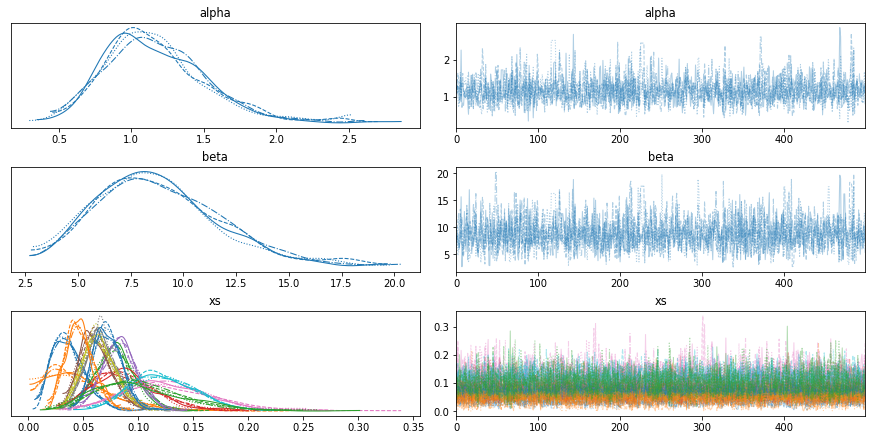

In [133]:
with model:
    az.plot_trace(trace)

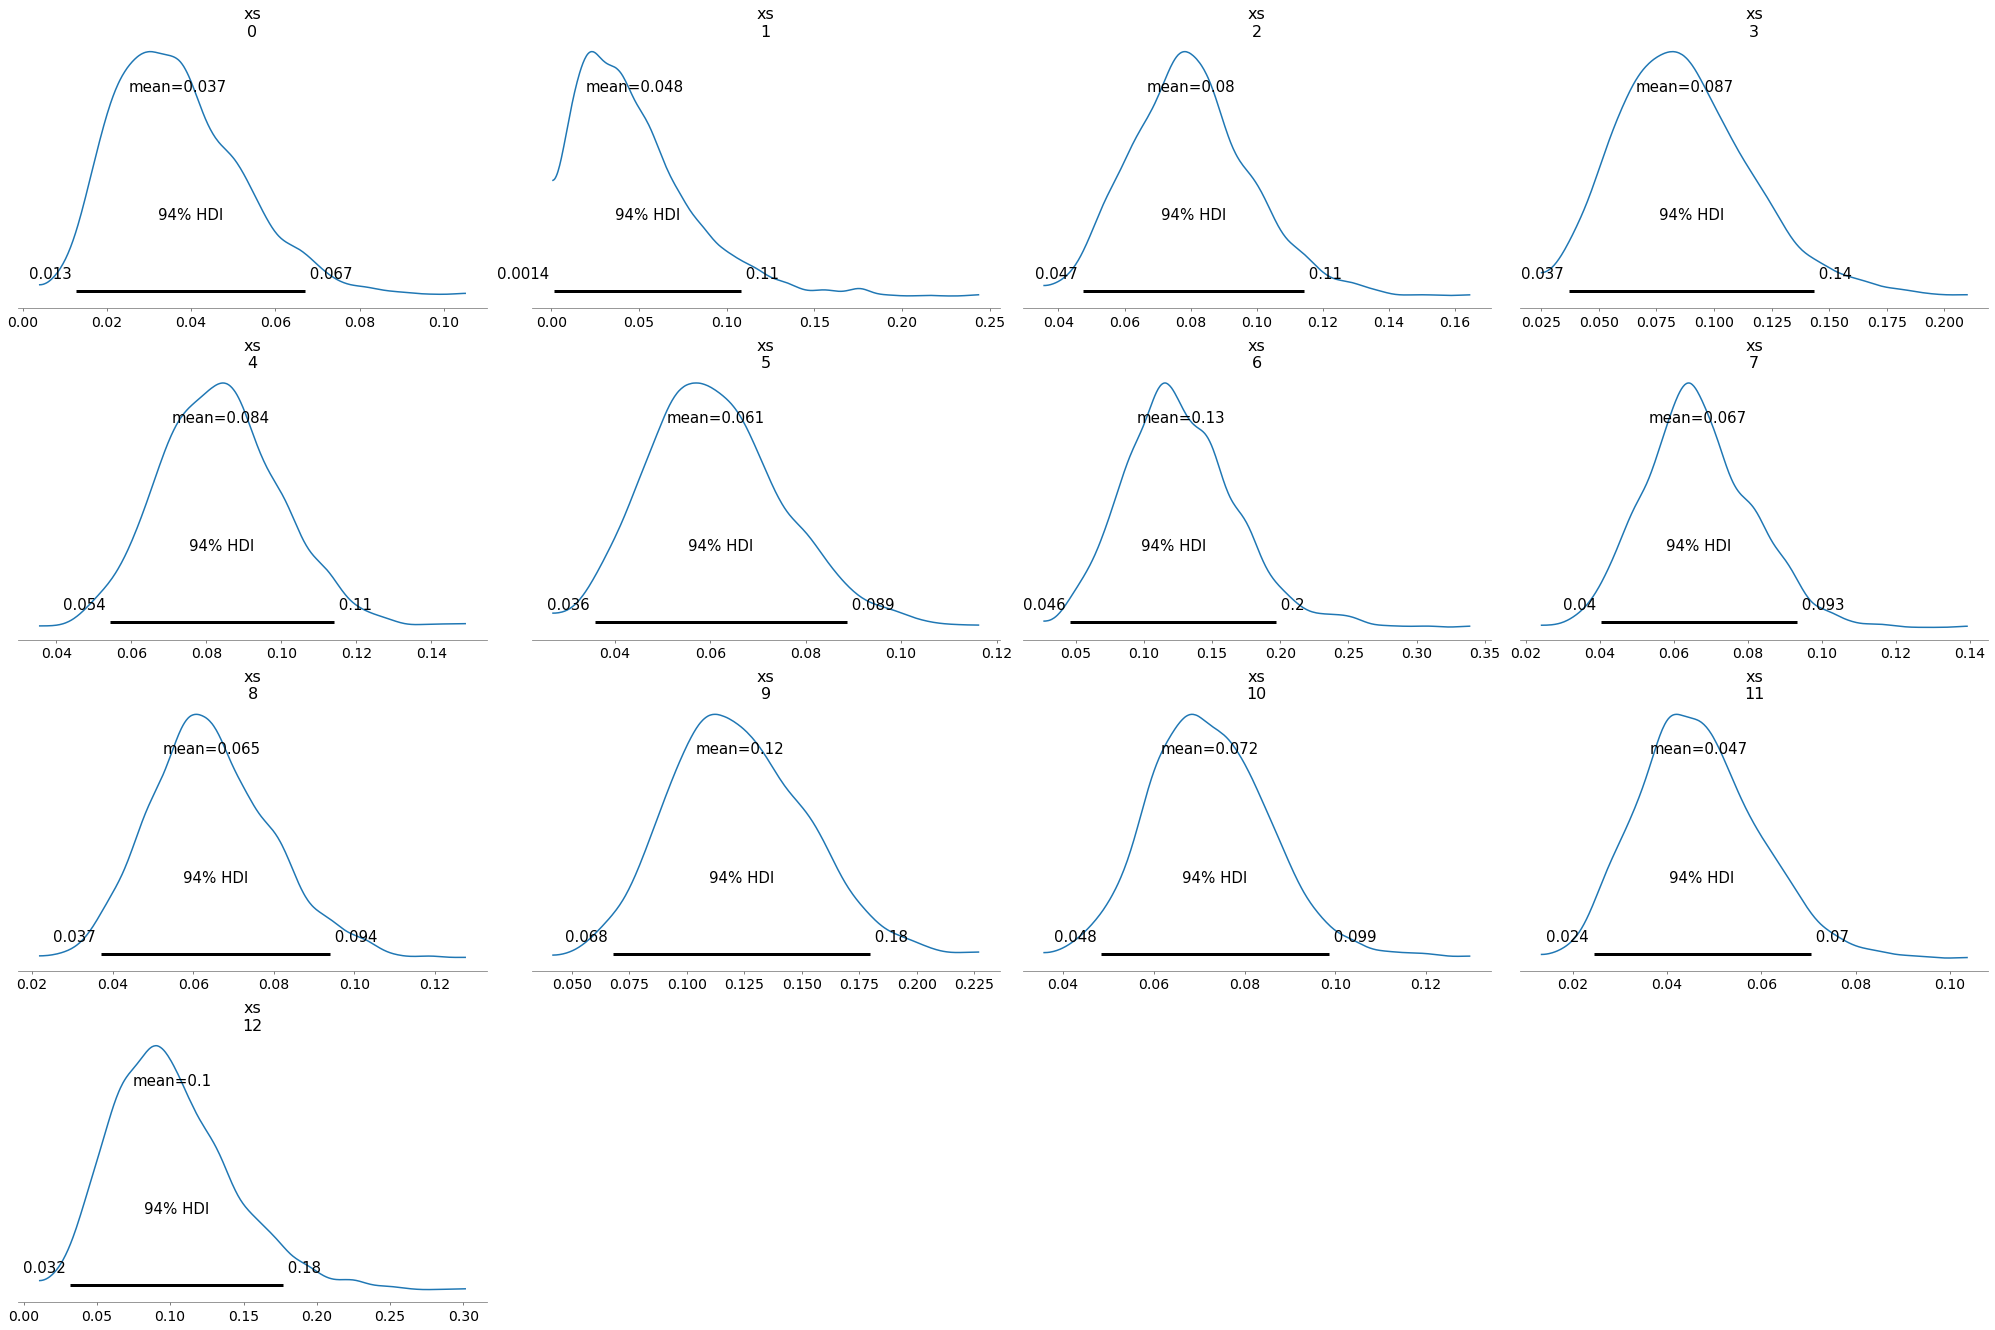

In [134]:
with model:
    az.plot_posterior(trace, var_names=['xs'])

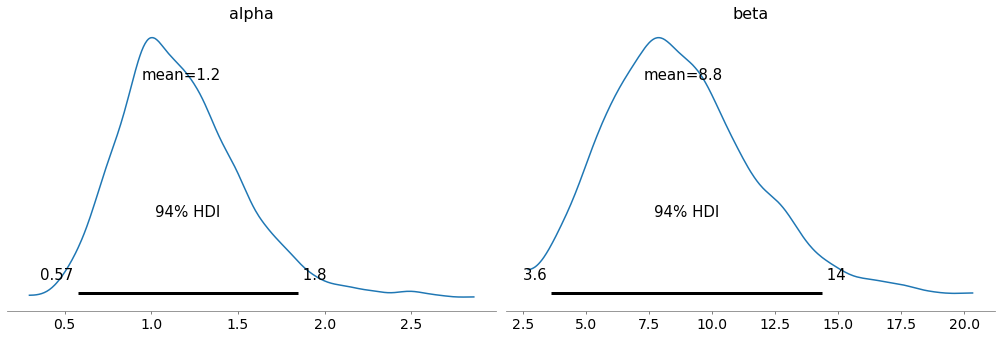

In [135]:
with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta'])

In [136]:
alphas = trace['alpha']
betas = trace['beta']

In [137]:
sample_posterior_x = pm.Beta.dist(alphas, betas).random()
sample_posterior_x.mean()

0.11998268351302108

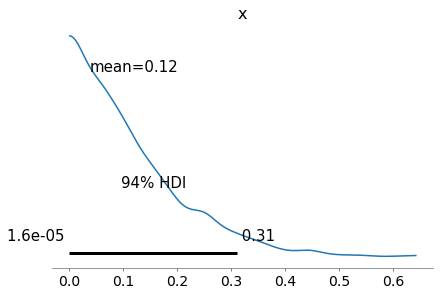

In [138]:
with model:
    az.plot_posterior(sample_posterior_x)

## Poisson model

The Poisson model is based on a gamma prior.  To choose the parameters of the prior, I used data from previous Stanley Cup finals and computed a maximum likelihood estimate (MLE).  But that's not correct, because

1. It assumes that the observed goal counts are the long-term goal-scoring rates.
2. It treats `alpha` and `beta` as known values rather than parameters to estimate.

In other words, I have ignored two important sources of uncertainty.  As a result, my predictions are almost certainly too confident.

The solution is a hierarchical model, where `alpha` and `beta` are the parameters that control `mu` and `mu` is the parameter that controls `goals`.  Then we can use observed `goals` to update the distributions of all three unknown parameters.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

Now that we have `alpha` and `beta`, we can generate `mu`.

In [56]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

/home/downey/anaconda3/envs/BayesianInferencePyMC/lib/python3.9/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Here's what the prior distribution of `mu` looks like.

In [57]:
def decorate_rate(ylabel='Density'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

In [58]:
sample_prior_mu = trace['mu']
np.mean(sample_prior_mu)

19.088821869685898

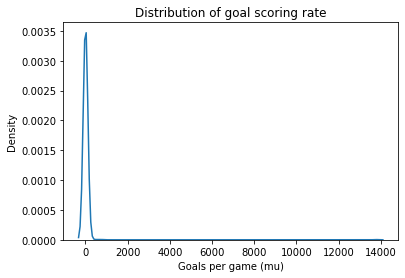

In [62]:
import seaborn as sns

sns.kdeplot(sample_prior_mu)
decorate_rate()

In effect, the model is saying "I have never seen a hockey game before.  As far as I know, it could be soccer, could be basketball, could be pinball."


The hierarchical model admits the possibility that `mu` could be orders of magnitude bigger. Unreasonable as that might seem, it's probably what we want in a non-committal prior.

Last step of the forward process, let's generate some goals.

In [63]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

Here's the prior predictive distribution of goals.

In [65]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')

    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

In [66]:
sample_prior_goals = trace['goals']
np.mean(sample_prior_goals)

6.5

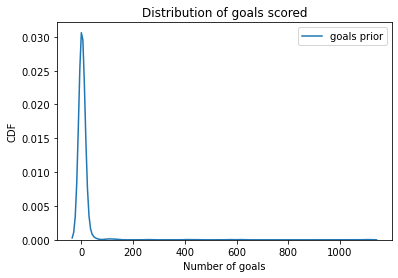

In [67]:
sns.kdeplot(sample_prior_goals, label='goals prior')
decorate_goals('CDF')

## Hierarchical inference

Once we have the forward process working, we only need a small change to run the reverse process.

In [68]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[4])
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


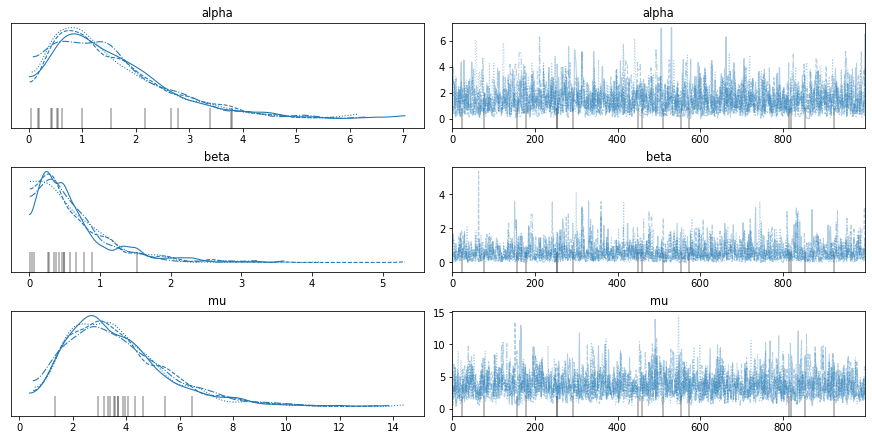

In [69]:
with model:
    az.plot_trace(trace)

Here's the posterior distribution of `mu`.  The posterior mean is close to the observed value, which is what we expect with a weakly informative prior.

In [70]:
sample_post_mu = trace['mu']
np.mean(sample_post_mu)

3.657186105306921

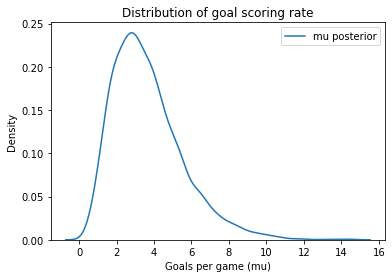

In [71]:
sns.kdeplot(sample_post_mu, label='mu posterior')
decorate_rate()

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [72]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    mu_MTL = pm.Gamma('mu_MTL', alpha, beta)
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[5,3])
    goals_MTL = pm.Poisson('goals_MTL', mu_MTL, observed=[1,1])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_MTL, mu_TBL, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


We can use `traceplot` to review the results and do some visual diagnostics.

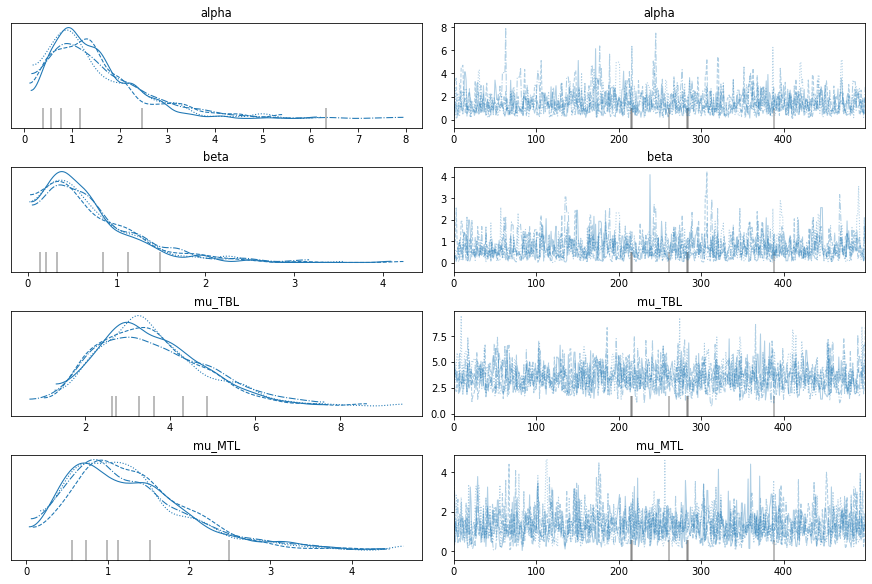

In [74]:
import arviz as az

with model:
    az.plot_trace(trace)

Here are the posterior distribitions for `mu_WSH` and `mu_VGK`.

In [75]:
mu_TBL = trace['mu_TBL']
mu_MTL = trace['mu_MTL']
np.mean(mu_MTL), np.mean(mu_TBL)

(1.287442536400577, 3.579780983714211)

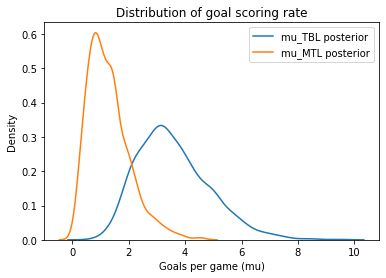

In [76]:
sns.kdeplot(mu_TBL, label='mu_TBL posterior')
sns.kdeplot(mu_MTL, label='mu_MTL posterior')
decorate_rate('Density')

On the basis of one game (and never having seen a previous game), here's the probability that Vegas is the better team.

In [77]:
np.mean(mu_TBL > mu_MTL)

0.963

## More background

But let's take advantage of more information.  Here are the results from the most recent Stanley Cup finals.
For games that went into overtime, I included only goals scored during regulation play.

In [78]:
data = dict(BOS13 = [3, 1, 2, 5, 1, 2],
            CHI13 = [3, 1, 0, 5, 3, 3],
            NYR14 = [2, 4, 0, 2, 2],
            LAK14 = [2, 4, 3, 1, 2],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 2, 1, 4, 1],
            PIT16 = [3, 1, 2, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6, 2, 1, 2, 3],
            WSH18 = [4, 3, 3, 6, 4],
            STL19 = [2, 2, 2, 4, 2, 1, 4],
            BOS19 = [4, 2, 7, 2, 1, 5, 1],
            DAL20 = [4, 2, 2, 4, 2, 0],
            TBL20 = [1, 3, 5, 4, 2, 2],
            MTL21 = [1, 1, 3, 2, 0],
            TBL21 = [5, 3, 6, 2, 1],
           )

Here's how we can get the data into the model.

In [79]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_TBL21, mu_MTL21, mu_TBL20, mu_DAL20, mu_BOS19, mu_STL19, mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 7 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


And here are the results.

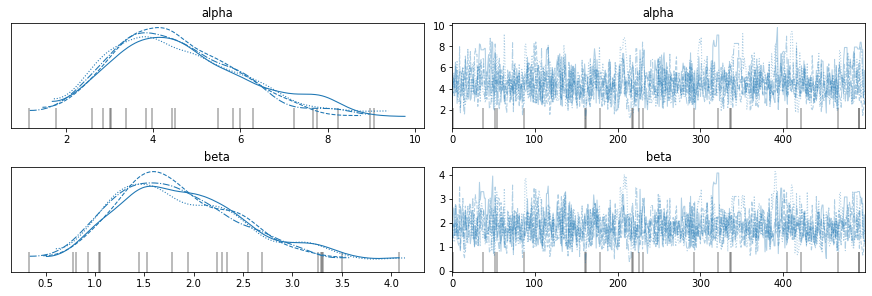

In [81]:
with model:
    az.plot_trace(trace, var_names=['alpha', 'beta'])

Here are the posterior means.

In [82]:
sample_post_alpha = trace['alpha']
np.mean(sample_post_alpha)

4.568430174203338

In [83]:
sample_post_beta = trace['beta']
np.mean(sample_post_beta)

1.862725020431783

In [87]:
sample_post_mu_TBL21 = trace['mu_TBL21']
sample_post_mu_MTL21 = trace['mu_MTL21']
sample_post_mu_TBL21.mean(), sample_post_mu_MTL21.mean()

(3.132810020868973, 1.6724153293544877)

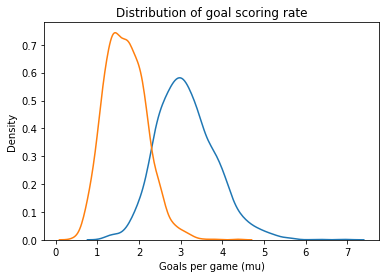

In [89]:
sns.kdeplot(sample_post_mu_TBL21)
sns.kdeplot(sample_post_mu_MTL21)
decorate_rate()

They are lower with the background information than without, and closer together.  Here's the updated chance that Vegas is the better team.

In [90]:
np.mean(sample_post_mu_TBL21 > sample_post_mu_MTL21)

0.965